**детектор объектов на изображений (HOG)**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
np.set_printoptions(precision=2)

Евгений Борисов   
О задаче поиска объекта на изображении. Часть 2: Применение методов машинного обучения.    
http://mechanoid.su/cv-image-detector2.html

## обучаем классификатор для детектора

### учебный датасет

In [2]:
# !pip3 install scikit-image

In [3]:
from skimage.io import imread

UIUC Image Database for Car Detection   
https://cogcomp.seas.upenn.edu/Data/Car/

https://disk.yandex.ru/d/KEZSpmlzTekTgw

In [5]:
folder_train = '../data/cars/train'

# позитивные примеры
with open(folder_train+'/pos/index.txt','rt') as f: files = f.read()
im_train_pos = np.stack([ imread(folder_train+'/pos/'+f) for f in files.split('\n') if f ])

# негативные примеры
with open(folder_train+'/neg/index.txt','rt') as f: files = f.read()
im_train_neg = np.stack([ imread(folder_train+'/neg/'+f) for f in files.split('\n') if f ])

del files

In [6]:
im_train_pos.shape, im_train_neg.shape

((550, 40, 100), (500, 40, 100))

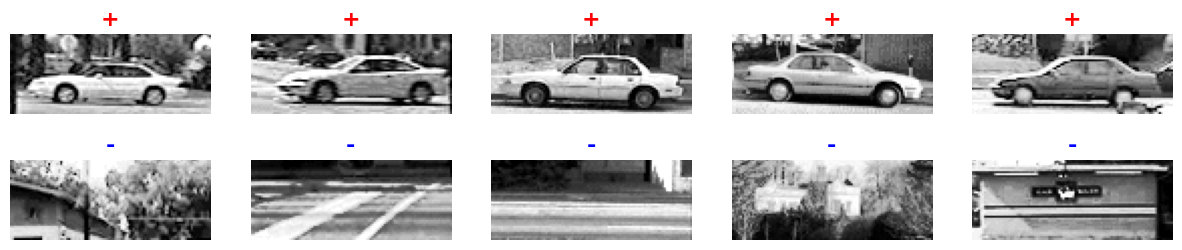

In [7]:
plt.figure(figsize=(15,3))

n_show = 5

ii = rng.permutation(  min( len(im_train_pos),len(im_train_neg) ) )[:n_show]
for n,i in enumerate(ii,start=1 ):
    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.title('+',color='r',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_train_pos[i],cmap='gray')
    
    plt.subplot(2,n_show,n+n_show)
    plt.axis(False)
    plt.title('-',color='b',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_train_neg[i],cmap='gray')

In [8]:
# размер учебного образа
im_train_size = im_train_pos.shape[1:]
im_train_size

(40, 100)

### извлекаем признаки

In [9]:
from skimage.feature import hog

In [10]:
ppc, cpb = (8,8), (2,2) # pixels per cell, cells per block

In [11]:
%%time

X_pos = np.array([ hog(x, pixels_per_cell=ppc, cells_per_block=cpb) for x in tqdm(im_train_pos) ])
X_neg = np.array([ hog(x, pixels_per_cell=ppc, cells_per_block=cpb) for x in tqdm(im_train_neg) ])

X,target = np.vstack([X_pos,X_neg]), np.array( [1]*len(X_pos) + [0]*len(X_neg) )

del X_pos
del X_neg

X.shape, target.shape

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 1.16 s, sys: 16.8 ms, total: 1.17 s
Wall time: 1.17 s


((1050, 1584), (1050,))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split( X, target, test_size=.2)
X_train.shape

(840, 1584)

In [13]:
del X
del target
del im_train_pos
del im_train_neg

### строим модель

In [14]:
%%time

from sklearn import svm

model = svm.SVC(probability=True).fit(X_train,target_train)

CPU times: user 624 ms, sys: 3.77 ms, total: 627 ms
Wall time: 628 ms


In [15]:
# оценка качества классификатора

from sklearn.metrics import classification_report

o_test = model.predict(X_test)
print(classification_report(target_test, o_test, target_names=['neg','pos']) ) 

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00        96
         pos       1.00      1.00      1.00       114

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



In [16]:
del X_train
del target_train

del X_test
del target_test

## детектор объектов

In [32]:
folder_data = '../data/cars/test'
with open(folder_data+'/index.txt','rt') as f:  
    files = [ s for s in f.read().split('\n') if s ]

141 217


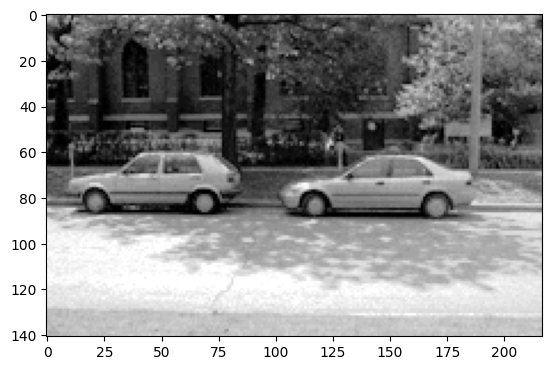

In [33]:
im = imread( folder_data+'/'+rng.choice(files) ) # случайный пример для теста детектора
im_height, im_width = im.shape
print(im_height, im_width )
plt.imshow(im,cmap='gray')

In [34]:
print(im_height, im_width )

141 217


### генератор фреймов

In [35]:
def make_frames(im_width,im_height):
    # минимальный размер окна
    frame_size_width_min = im_width//10
    frame_size_height_min = im_height//10 
    
    # максимальный размер окна
    frame_size_width_max  = im_width 
    frame_size_height_max = im_height
 
    # шаг изменения позиции окна
    frame_step_width  = max( im_width//20,  1 ) 
    frame_step_height = max( im_height//10, 1 ) 
    
    # шаг изменения размера окна
    frame_step_pos_x = max(im_width//10,10) 
    frame_step_pos_y = max(im_height//10,10) 

    return [
        [ px, py, w, h ]
        for w in range(frame_size_width_min,frame_size_width_max,frame_step_width)
        for h in range(frame_size_height_min,frame_size_height_max,frame_step_height) # if w>h*1.5
        for px in range(0,im_width-w,frame_step_pos_x)
        for py in range(0,im_height-h,frame_step_pos_y)
    ] + [
        [ im_width-w-1, im_height-h-1, w, h ]
        for w in range( frame_size_width_min,  frame_size_width_max,  frame_step_width  )
        for h in range( frame_size_height_min, frame_size_height_max, frame_step_height ) # if w>h*1.5
    ]

In [36]:
# рисуем фрейм
def draw_frame(im_rgb,px,py,w,h,c=(255,0,0)):
    im_rgb[py,     px:px+w ] = c 
    im_rgb[py:py+h,px      ] = c 
    im_rgb[py+h,   px:px+w ] = c
    im_rgb[py:py+h,px+w    ] = c 
    return im_rgb

# рисуем список фреймов
def draw_frames(im_gray,frames,c=(255,0,0)):
    im_rgb = np.stack([im_gray,im_gray,im_gray,],axis=-1) 
    for frame in frames: im_rgb = draw_frame(im_rgb,*frame,c)
    return im_rgb

In [37]:
frames = make_frames(im_width,im_height)
len(frames) # количество фреймов

6030

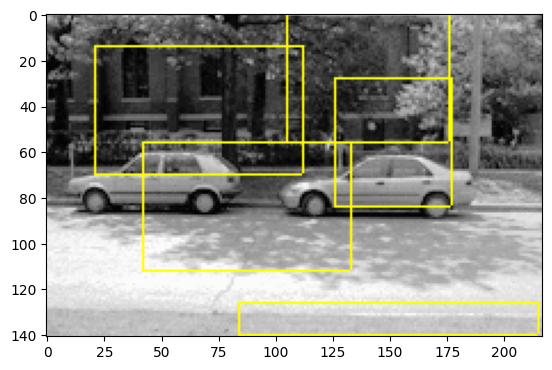

In [38]:
# рисуем случайно выбиранные фреймы для демонстрации
frames_ =  [ frames[i] for i in rng.permutation(len(frames))[:5] ]
plt.imshow( draw_frames( im, frames_, c=(255,255,0),) )

далее каждый фрейм оцениваем классификатором (есть машинка в кадре или нет)

### вынимаем признаки из каждого фрейма

In [39]:
from skimage.transform import resize

get_frame_coo = lambda im,x,y,w,h: im[y:y+h,x:x+w]

def frame2hog(frame,im_train_size=im_train_size,ppc=ppc,cpb=cpb):
    return hog( # считаем гистограмму направленных градиентов для фрейма
      resize( # масштабируем фрейм до размера совместимого со входом классификатора
          get_frame_coo(im,*frame), # вырезаем фрейм из картинки 
          im_train_size, 
          preserve_range=True 
      ).astype(np.uint8)
      ,pixels_per_cell=ppc
      ,cells_per_block=cpb
    )    

In [40]:
%%time

X = np.stack([ frame2hog(frame) for frame in tqdm(frames) ])

X.shape

  0%|          | 0/6030 [00:00<?, ?it/s]

CPU times: user 7.98 s, sys: 20.1 ms, total: 8 s
Wall time: 7.99 s


(6030, 1584)

### отбираем гипотезы с достаточно большой оценкой

In [41]:
prob_threshold = .97 # порог минимальной оценки

hypotheses_prob = model.predict_proba(X)[:,1]

ii = np.where( hypotheses_prob>prob_threshold)[0]
hypotheses  = [ frames[i] for i in ii ]
hypotheses_prob  = [ hypotheses_prob[i] for i in ii ]
print( len(hypotheses) )

40


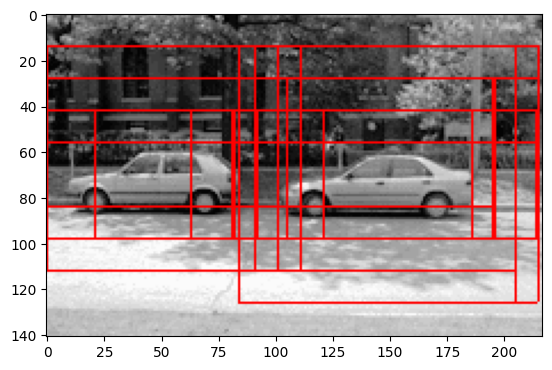

In [42]:
plt.imshow( draw_frames(im,hypotheses,c=(255,0,0)) )

### редуцируем фреймы-кандидаты (NMS)

Non-maximum suppression

https://habr.com/ru/company/jetinfosystems/blog/498294/

оцениваем степень наложения фреймов друг на друга и выкидываем лишнее

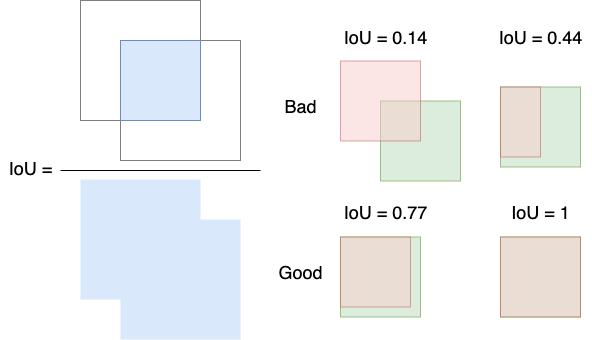

In [43]:
def area(frame): # площадь фрейма
    _,_,w,h = frame
    return w*h 

def area_intersect(frame0, frame1): # площадь пересечения двух фреймов
    x0,y0,w0,h0 = frame0
    x1,y1,w1,h1 = frame1
    dx = min(x0+w0, x1+w1) - max(x0,x1)
    dy = min(y0+h0, y1+h1) - max(y0, y1)
    if (dx>=0) and (dy>=0): return dx*dy
    return 0

def area_union(frame0, frame1): # площадь объединения двух фреймов
    return area(frame0)+area(frame1) - area_intersect(frame0,frame1)
    
def iou(frame0, frame1): #  Intersection over Union, оценка степени наложения двух фреймов
    return area_intersect(frame0, frame1) /  area_union(frame0, frame1)

def sort_hypotheses(hypotheses,hypotheses_prob): # сортируем гипотезы по убыванию оценки
    return [ hypotheses[i] for i in np.argsort(hypotheses_prob)[::-1] ]

# Non-maximum suppression - удаление лишних фреймов
def nms(hypotheses,hypotheses_prob,iou_threshold = .2): 
    result = [] # список результатов
    # cортируем гипотезы по убыванию оценки
    #    формируем очередь для обработки
    queue = sort_hypotheses(hypotheses,hypotheses_prob) 
    while len(queue)>0: # пока очередь не пустая
        h0 = queue[0] # гипотеза с наилучшей оценкой в очереди
        result.append(h0) # ...докидываем её в результаты
        # выкидываем из очереди h0 и все фреймы близкие к h0 
        queue = [ h1 for h1 in queue[1:] if iou(h0,h1)<iou_threshold ]
    return result

### результат

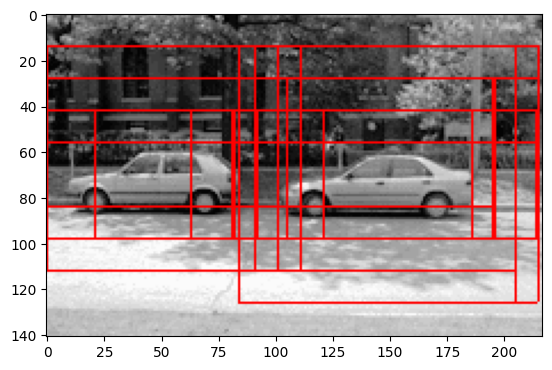

In [44]:
plt.imshow( draw_frames(im,hypotheses,c=(255,0,0)) )

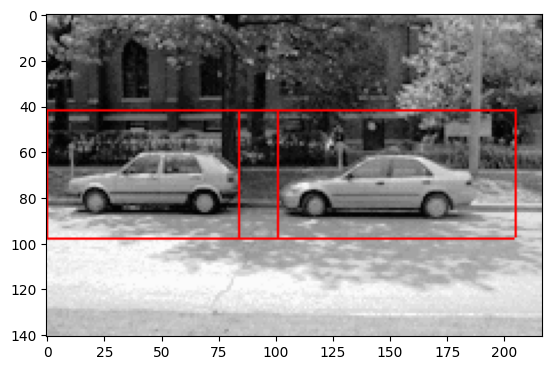

In [45]:
result = nms(hypotheses,hypotheses_prob,iou_threshold=.2)
plt.imshow( draw_frames(im,result,c=(255,0,0)) )